# Context

Recent studies have shown that breast cancer continues to be the leading cause of death among women over the world. If detected at an early stage, it can be cured in 9 out of 10 cases.

Automated detection and segmentation of cells from images are the crucial and fundamental steps for the measurement of cellular morphology that is crucial for brest cancer diagnosis and prognosis.


In this notebook, you will learn how to train a segmentation as UNet with **monai** - a framwork based Pytorch Stadard for healthcare imaging.

## Monai

MONAI is a pytorch based open source AI framework launched by NVIDIA and King’s College London.
It is integrated with training and modelling workflows in a native PyTorch Standard. t several places.


Install monai

In [1]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.2 MB/s eta 0:00:00a 0:00:01


Check the installation by running the following cell

In [2]:
import monai
monai.config.print_config()

/opt/conda/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
US1_J2KR.dcm:   0%|          | 38.0/154k [00:00<05:46, 444B/s]
MR-SIEMENS-DICOM-WithOverlays.dcm:   0%|          | 125/511k [00:00<10:23, 819B/s] 
OBXXXX1A.dcm:   0%|          | 119/486k [00:00<09:24, 860B/s] 
US1_UNCR.dcm:   0%|          | 226/923k [00:00<11:40, 1.32kB/s]
color3d_jpeg_baseline.dcm:   0%|          | 1.50k/6.14M [00:00<17:59, 5.69kB/s]


MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.4.0+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.1
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.23.2
scipy version: 1.14.1
Pillow version: 10.4.0
Tensorboard version: 2.16.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.19.0+cpu
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: 2.2.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.44.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    ht

#  Dataset

To train a model, we need to prepare some ingredients:

1. Dataset
2. Model
3. Loss function
4. Optimizer

# I. Create Dataset

There are two ways to create your dataset:
- with pytorch Dataset
- with monai.data.Dataset.

In this exercise, we will create our dataset using torch.utils.data.Dataset.

## 1. List all files in folder

Download the dataset from https://zenodo.org/record/1175282#.YMn_Qy-FDox

Notice that there are two kind of folder : original cell picture folder and mask folders. Using your file explorer or some code, display one image and the corresponding image

Let's start by getting the data. While trying to upload it on my kaggle, I found out there were already a dataset with these exact data, so I proceeded to use it instead.

In [3]:
data_path = "/kaggle/input/tnbc-nuclei-segmentation-original-dataset/TNBC_NucleiSegmentation"

In [4]:
import os

image_files = []
label_files = []

for subdir in os.listdir(data_path):
    folder_path = os.path.join(data_path, subdir)
    if subdir.find('GT') == 0:
        label_files += [os.path.join(folder_path, file) for file in os.listdir(folder_path)]
    if subdir.find('Slide') == 0:
        image_files += [os.path.join(folder_path, file) for file in os.listdir(folder_path)]

Number of data

In [5]:
print(f"Number of images: {len(image_files)}")

Number of images: 50


Displaying an image and its associated mask

In [6]:
image_files

['/kaggle/input/tnbc-nuclei-segmentation-original-dataset/TNBC_NucleiSegmentation/Slide_02/02_1.png',
 '/kaggle/input/tnbc-nuclei-segmentation-original-dataset/TNBC_NucleiSegmentation/Slide_02/02_2.png',
 '/kaggle/input/tnbc-nuclei-segmentation-original-dataset/TNBC_NucleiSegmentation/Slide_02/02_3.png',
 '/kaggle/input/tnbc-nuclei-segmentation-original-dataset/TNBC_NucleiSegmentation/Slide_03/03_1.png',
 '/kaggle/input/tnbc-nuclei-segmentation-original-dataset/TNBC_NucleiSegmentation/Slide_03/03_3.png',
 '/kaggle/input/tnbc-nuclei-segmentation-original-dataset/TNBC_NucleiSegmentation/Slide_03/03_5.png',
 '/kaggle/input/tnbc-nuclei-segmentation-original-dataset/TNBC_NucleiSegmentation/Slide_03/03_4.png',
 '/kaggle/input/tnbc-nuclei-segmentation-original-dataset/TNBC_NucleiSegmentation/Slide_03/03_2.png',
 '/kaggle/input/tnbc-nuclei-segmentation-original-dataset/TNBC_NucleiSegmentation/Slide_11/11_2.png',
 '/kaggle/input/tnbc-nuclei-segmentation-original-dataset/TNBC_NucleiSegmentation/

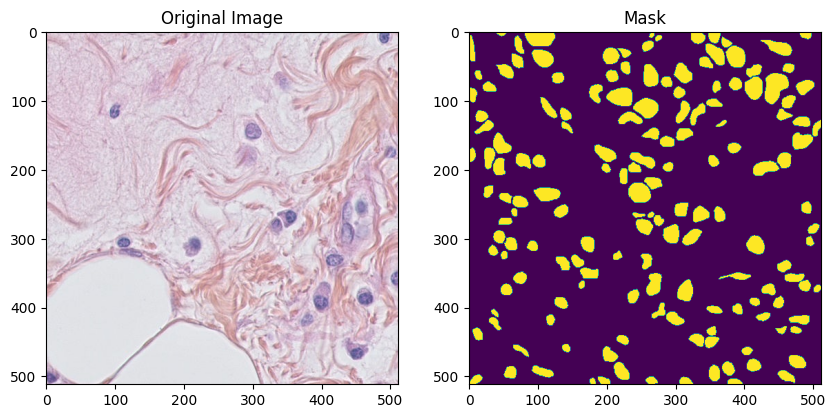

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(Image.open(image_files[0]))
ax1.set_title('Original Image')
ax2.imshow(Image.open(label_files[0]))
ax2.set_title('Mask')
plt.show()

## 2. Define a transform
When you load your data, you need to define some transformation. For example, we want to convert image to the format [num_channels, spatial_dim_1, spatial_dim_2] because monai/pytorch use this format. We'll also need to convert the images to PyTorch tensors with transforms.ToTensor()

The following code lets you load image and the labels and define several steps to transform the data.


In [8]:
import torch

from monai.transforms import Compose, LoadImage, EnsureChannelFirst, ToTensor, NormalizeIntensity
from monai.transforms import ScaleIntensity

from monai.data import PILReader

image_trans = Compose(
    [
        LoadImage(image_only=True, reader = PILReader(converter=lambda image: image.convert("RGB"))),
        EnsureChannelFirst(),
        NormalizeIntensity(),
        ToTensor(),
    ])


label_trans = Compose(
    [
        LoadImage(image_only=True),
        ScaleIntensity(),
        ToTensor(),
    ])


## 3. Create dataset

The following class CellDataset allows us to create our dataset from "image_files" and "label_files" where:
- "image_files" is a list of image names
- "label_files" is the list of segmentation names respectively.

"im_trans" and "label_trans" are respectively the transforms for the images and their labels.




In [9]:
import torch

class CellDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, label_files, im_trans, label_trans):
        self.image_files = image_files
        self.label_files = label_files
        self.im_trans = im_trans
        self.label_trans = label_trans

    def __len__(self):
        return(len(self.image_files))

    def __getitem__(self, index):
        return self.im_trans(self.image_files[index]), self.label_trans(label_files[index])



By using this class, create your training dataset et your test dataset. Remember to check if your dataset is loaded correctly.

In [10]:
# Let's choose a 80-20 split for train-test
train_size = int(0.8 * len(image_files))

train_dataset = CellDataset(image_files[:train_size], label_files[:train_size], image_trans, label_trans)
test_dataset = CellDataset(image_files[train_size:], label_files[train_size:], image_trans, label_trans)

## 4. DataLoader

With the your dataset loaded, you have to pass it to a DataLoader. The torch.utils.data.DataLoader takes a dataset and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.


The following code let you create a data loader for the train dataset, do the same to create a test_loader on the test_dataset. Name it **test_load**


In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

## 5. Now, time to check your dataloader.

Execute the code following to check if your dataloader works correctly

In [12]:
import monai
im, seg = monai.utils.misc.first(train_loader)
im.shape

torch.Size([4, 3, 512, 512])

# II. Build your segmentation model with monai

Monai already has a UNet model architecture : https://docs.monai.io/en/stable/networks.html#unet

By using the monai.networks.nets module, build a UNet model for segmentation task in 2D. You'll have to choose the following parameters for the model:

1. dimensions (number of spatial dimensions)
2. in_channels (number of input channel)
3. out_channels (number of output channel)
4. channels
5. strides


In [13]:
from monai.networks.nets import UNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)
model

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit

# III. Define your loss function and optimizer

For a segmentation prob, we usually use DiceLoss.
Using monai.losses.DiceLoss, define your loss function and store it in the variable named **loss_function**. The option sigmoid = True should be used.




In [14]:
from monai.losses import DiceLoss

loss_function = DiceLoss(sigmoid=True)

With torch.optim, define an optimizer for your model. Use the Adam optimiser



In [15]:
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# IV. Trainning the model

This time, we have all ingredients to train a segmentation model: a model, an optimizer, train_loader and a loss function.  

Monai use a standard PyTorch program style for training a deep learning model.


The general process with Monai/Pytorch just for one learning step  as follows:

1. Load input and label of each batch.

2. Zero accumulated gradients with optimizer.zero_grad()

3. Compute the output from the model

4. Calculate the loss

5. Perform backprop with loss.backward()

6. Update the optimizer with optimizer.step()


Complete the following code so that it do the training


In [16]:
epoch_loss_values = list()
for epoch in range(2):
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        
        # Add a channel dimension to labels if it's missing
        if labels.dim() == 3:
            labels = labels.unsqueeze(1)
        
        optimizer.zero_grad()
        
        # Compute the model predictions
        predictions = model(inputs)
 
        # Compute the loss
        loss = loss_function(predictions, labels)
        
        # Compute the gradient of the loss
        loss.backward()
        
        # Update the model parameters
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
    
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

1/10, train_loss: 0.8219
2/10, train_loss: 0.7753
3/10, train_loss: 0.7236
4/10, train_loss: 0.7850
5/10, train_loss: 0.9244
6/10, train_loss: 0.8143
7/10, train_loss: 0.7783
8/10, train_loss: 0.7779
9/10, train_loss: 0.8330
10/10, train_loss: 0.7771
epoch 1 average loss: 0.8011
1/10, train_loss: 0.8320
2/10, train_loss: 0.7219
3/10, train_loss: 0.7914
4/10, train_loss: 0.8122
5/10, train_loss: 0.8934
6/10, train_loss: 0.7980
7/10, train_loss: 0.7658
8/10, train_loss: 0.7776
9/10, train_loss: 0.8132
10/10, train_loss: 0.7906
epoch 2 average loss: 0.7996


Display the prediction of your model on several image

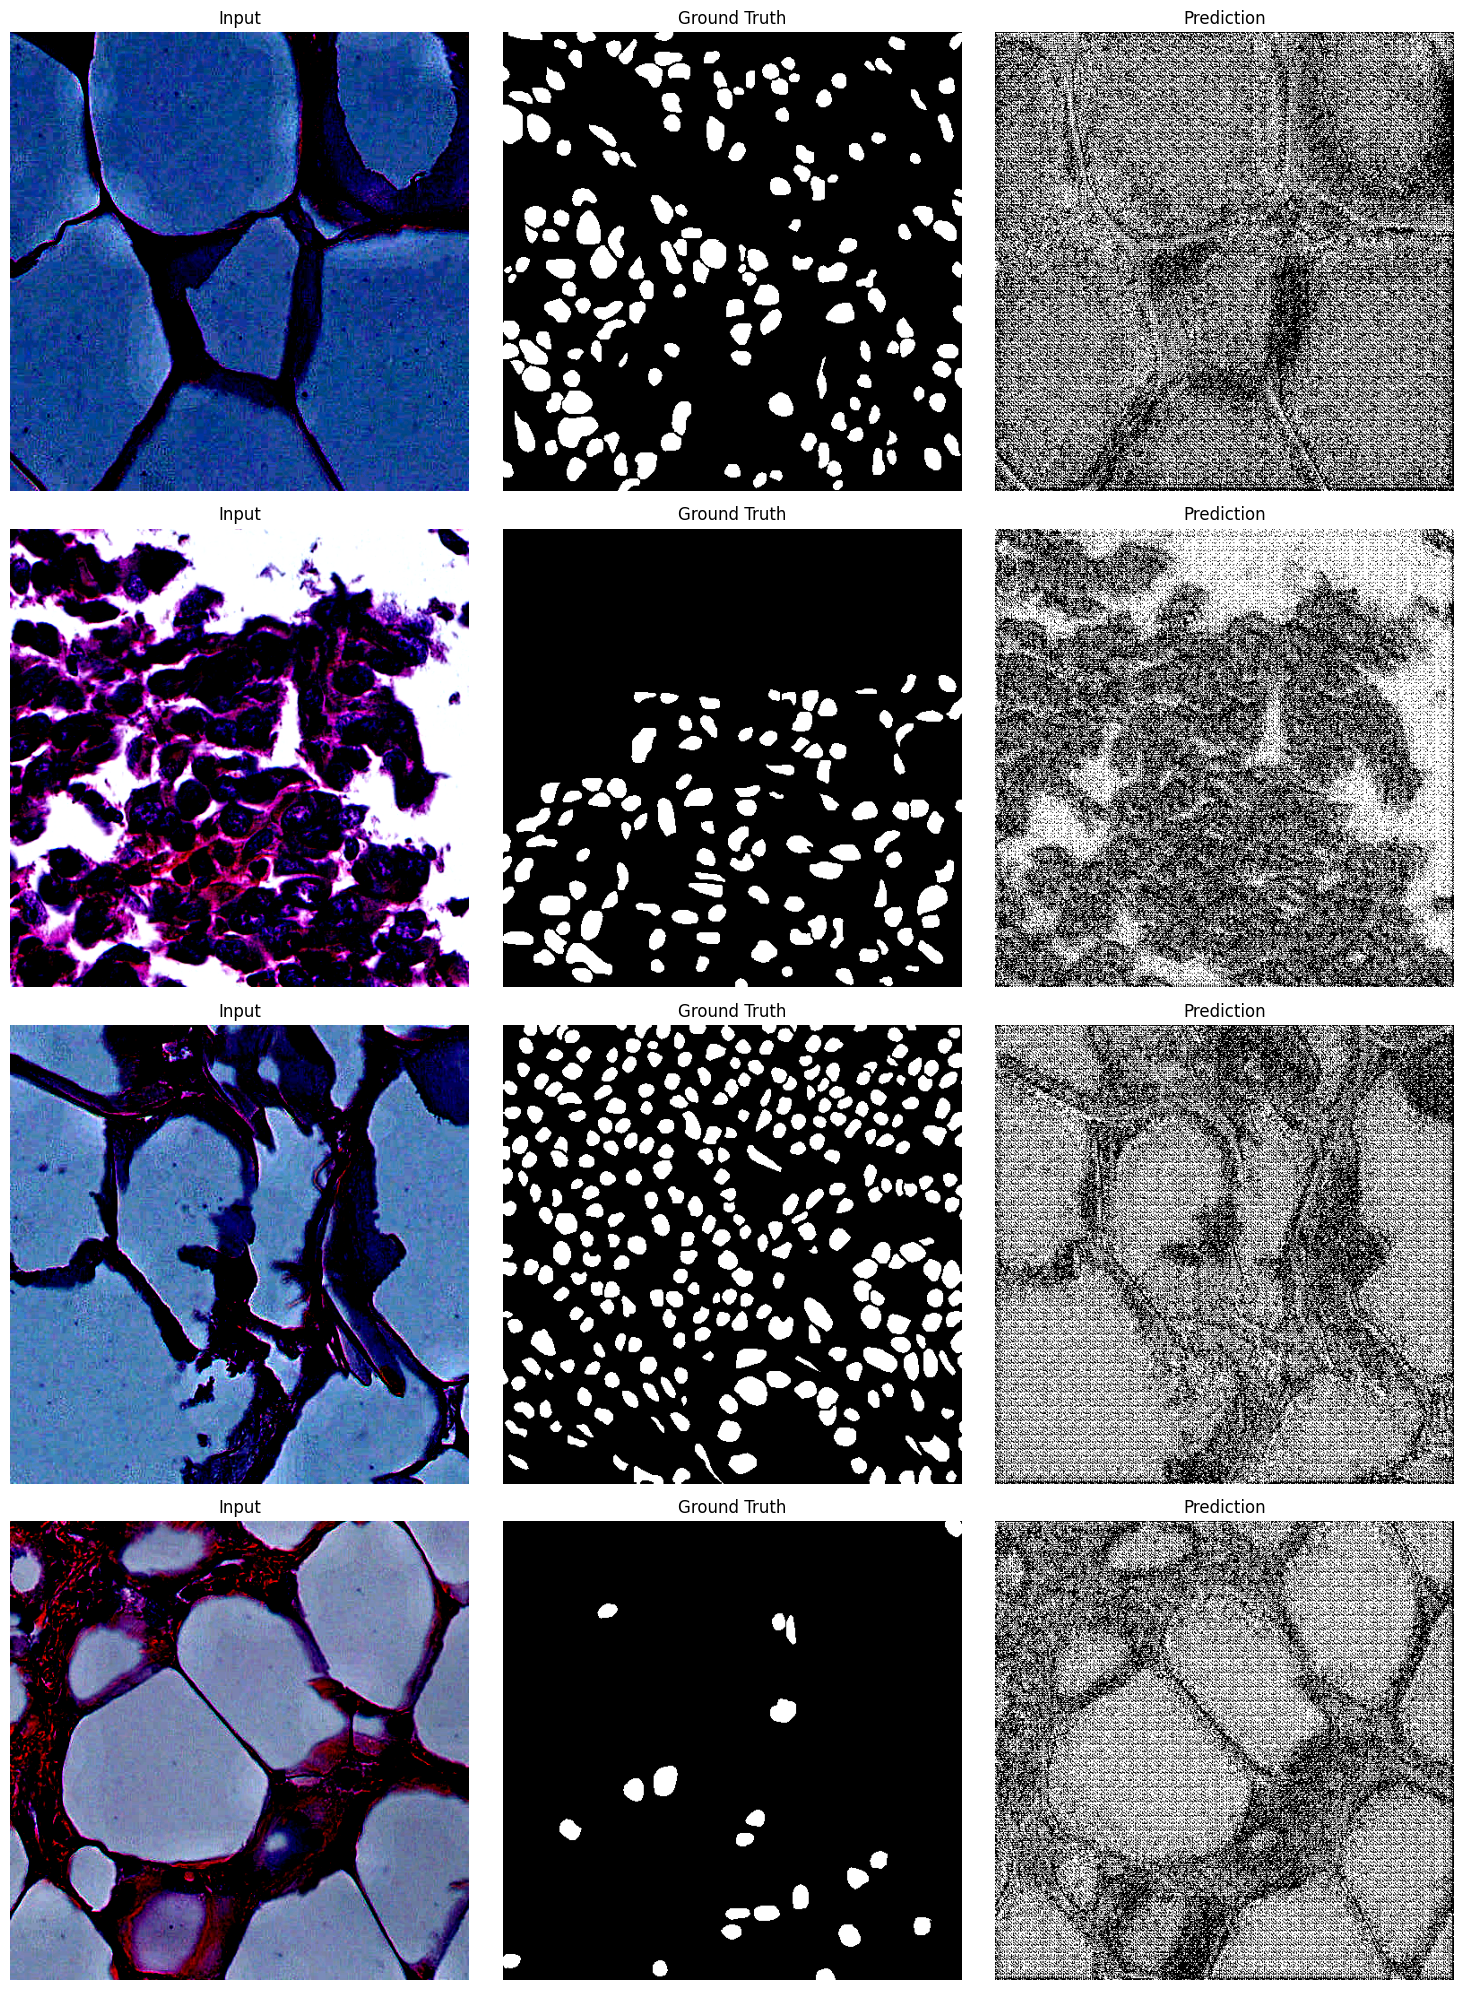

In [17]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        # Convert to numpy for visualization
        inputs = inputs.cpu().numpy()
        labels = labels.cpu().numpy()
        outputs = outputs.cpu().numpy()
        
        # Plot the results
        fig, axes = plt.subplots(4, 3, figsize=(15, 20))
        for j in range(4):
            # Input image
            if inputs.shape[1] == 3:  # RGB image
                axes[j, 0].imshow(inputs[j].transpose(1, 2, 0))
            else:  # Grayscale image
                axes[j, 0].imshow(inputs[j, 0], cmap='gray')
            axes[j, 0].set_title('Input')
            axes[j, 0].axis('off')
            
            # Ground truth
            label_img = labels[j] if labels.ndim == 3 else labels[j, 0]
            axes[j, 1].imshow(label_img, cmap='gray')
            axes[j, 1].set_title('Ground Truth')
            axes[j, 1].axis('off')
            
            # Prediction
            output_img = outputs[j] if outputs.ndim == 3 else outputs[j, 0]
            axes[j, 2].imshow(output_img > 0.5, cmap='gray')
            axes[j, 2].set_title('Prediction')
            axes[j, 2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        if i == 0:  # Only show the first batch
            break

Train another architecture (either another Unet architecture or find another segmentation model in the available models of Monai). Compare the results with the first model

In [18]:
from monai.networks.nets import SegResNet

model2 = SegResNet(
    spatial_dims=2,
    init_filters=16,
    in_channels=3,
    out_channels=1,
).to(device)

loss_function2 = DiceLoss(sigmoid=True)
optimizer2 = torch.optim.Adam(model2.parameters(), 1e-4)

# Training loop
epoch_loss_values2 = list()
for epoch in range(2):
    model2.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        
        # Add channel dimension to labels if it's missing
        if labels.dim() == 3:
            labels = labels.unsqueeze(1)
        
        optimizer2.zero_grad()
        predictions = model2(inputs)
        loss = loss_function2(predictions, labels)
        loss.backward()
        optimizer2.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values2.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

1/10, train_loss: 0.8131
2/10, train_loss: 0.7488
3/10, train_loss: 0.8337
4/10, train_loss: 0.8275
5/10, train_loss: 0.7844
6/10, train_loss: 0.7872
7/10, train_loss: 0.8305
8/10, train_loss: 0.8233
9/10, train_loss: 0.8537
10/10, train_loss: 0.7346
epoch 1 average loss: 0.8037
1/10, train_loss: 0.8001
2/10, train_loss: 0.7471
3/10, train_loss: 0.8386
4/10, train_loss: 0.8516
5/10, train_loss: 0.8231
6/10, train_loss: 0.8178
7/10, train_loss: 0.8285
8/10, train_loss: 0.7864
9/10, train_loss: 0.7187
10/10, train_loss: 0.7655
epoch 2 average loss: 0.7978


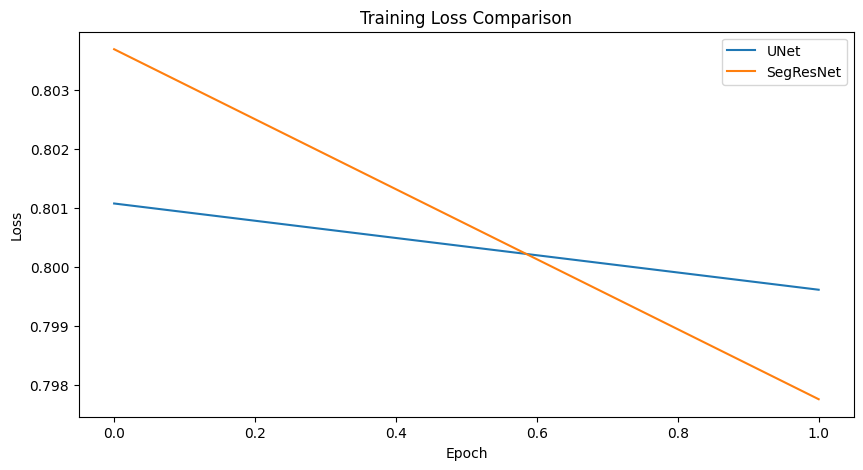

In [19]:
# Comparison of loss curves
plt.figure(figsize=(10, 5))
plt.plot(epoch_loss_values, label='UNet')
plt.plot(epoch_loss_values2, label='SegResNet')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


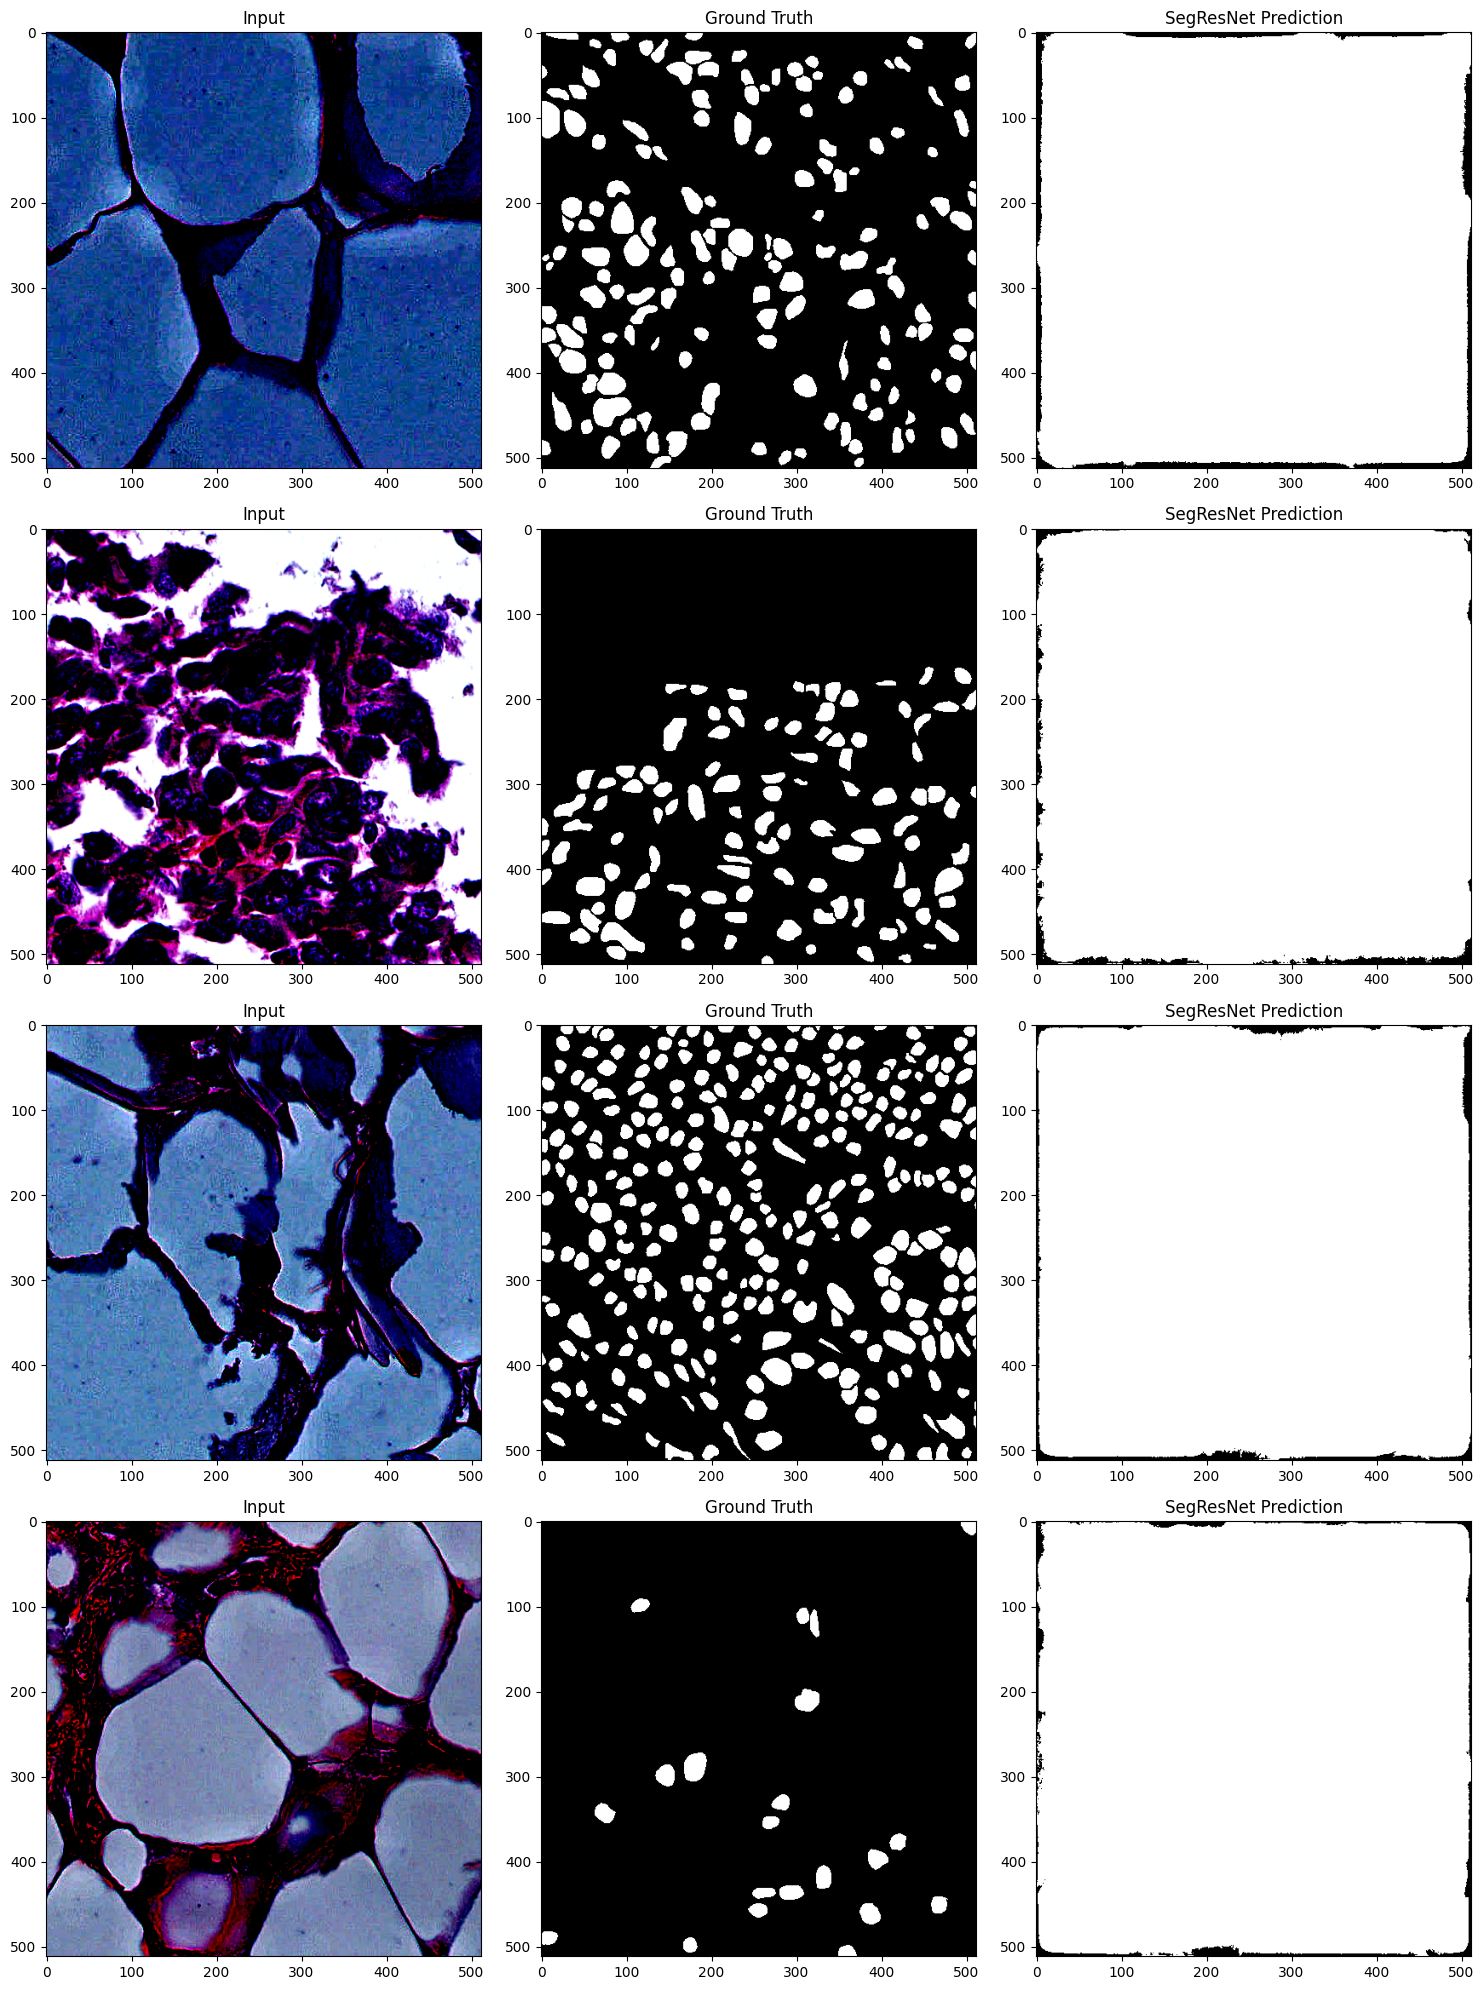

In [20]:
# Display predictions from SegResNet
model2.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Add channel dimension to labels if it's missing
        if labels.dim() == 3:
            labels = labels.unsqueeze(1)
        
        outputs = model2(inputs)
        
        # Convert to numpy for visualization
        inputs = inputs.cpu().numpy()
        labels = labels.cpu().numpy()
        outputs = outputs.cpu().numpy()
        
        # Plot the results
        fig, axes = plt.subplots(4, 3, figsize=(15, 20))
        for j in range(4):
            axes[j, 0].imshow(inputs[j].transpose(1, 2, 0))
            axes[j, 0].set_title('Input')
            axes[j, 1].imshow(labels[j, 0], cmap='gray')
            axes[j, 1].set_title('Ground Truth')
            axes[j, 2].imshow(outputs[j, 0] > 0.5, cmap='gray')
            axes[j, 2].set_title('SegResNet Prediction')
        plt.tight_layout()
        plt.show()
        
        if i == 0:  # Only show the first batch
            break